# 13.4

In [308]:
import matplotlib.pyplot as plt
import sys
sys.path.append('C:/Users/jeff8')
datapath = 'C:/Users/jeff8/mlrefined_datasets/nonlinear_superlearn_datasets/'

from autograd import numpy as np
from autograd import value_and_grad
from matplotlib import gridspec

In [309]:
# Define

def feature_transforms (a, w):
    # loop through each layer
    for W in w:
        # compute inner -product with current layer weights
        a = W[0] + np.dot(a.T, W[1:])
        # pass through activation
        a = np.tanh(a).T
    return a

# neural network model
def model(x, theta):
    # compute feature transformation
    f = feature_transforms (x, theta [0])
    # compute final linear combination
    a = theta [1][0] + np.dot(f.T, theta[1][1:])
    return a.T

# create initial weights for a neural network model
def network_initializer (layer_sizes, scale):
    # container for all tunable weights
    weights = []
    # create appropriately -sized initial
    # weight matrix for each layer of network
    for k in range(len( layer_sizes ) -1):
        # get layer sizes for current weight matrix
        U_k = layer_sizes [k]
        U_k_plus_1 = layer_sizes [k+1]
        # make weight matrix
        weight = scale * np.random.randn(U_k+1, U_k_plus_1)
        weights.append(weight)
# repackage weights so that theta_init [0] contains all
# weight matrices internal to the network, and theta_init [1]
# contains final linear combination weights
    theta_init = [weights [: -1], weights [ -1]]
    return theta_init

# optimizer to update all parameters
def gradient_descent_optimizer(w, dw, alpha=0.01):
    def helper(W, DW):
        ''' recursive update weight'''
        assert len(W) == len(DW)
        if type(W) == list:
            for i in range(len(W)):
                helper(W[i], DW[i])
        elif type(W) == np.ndarray:
            W -= alpha * DW
        else:
            raise NotImplemented()
    helper(w, dw)
    return w

# train the model until accuracy reach 1.0
def train(model, w, dataset, loss_f, alpha=0.01, epoch_total=1000):
    x = dataset['input']
    y = dataset['output']
    print(x.shape)
    assert x.shape[0] == y.shape[0]
    dataset_size = x.shape[0]
    cost_history = []
    acc_history = []
    # define loss function
    def get_loss(x, w, y):
        output = model(x, w)
        loss = loss_f(output, y)
        return loss
    loss_and_dloss = value_and_grad(get_loss, 1)

    epoch = 1
    while epoch < epoch_total:
        epoch += 1
        if epoch % 10000 == 0:
            print('epoch: %d, loss: %f' % (epoch, cost_history[-1]))
        loss, grad_value = loss_and_dloss(x, w, y)
        acc_history.append(evaluate(model, w, dataset))
        cost_history.append(loss)
        if abs(acc_history[-1] - 1) < 1e-6:
            break
        # gradient descent step
        w = gradient_descent_optimizer(w, grad_value, alpha)
    return acc_history, cost_history, w

def ls_loss(output, gt):
    ret = np.power(output-gt, 2).sum(axis=0)
    ret = ret.mean()
    return ret

def encoder_decoder_model(x, w):
    assert len(w) == 2
    encoder_w, decoder_w = w[0], w[1]
    z = model(x, encoder_w)
    # z = activation(z)
    y = model(z, decoder_w)
    # y = activation(y)
    return y


def plot_scatter_manifold(x, model, w):
    fig = plt.figure()
    gs = gridspec.GridSpec(1, 3)
    
    # map the data
    mapped = model(x, w)

    # learned manifold. Map all points sampled from surface

    xlin1 = np.linspace(-2.5,-1.7, 200)
    xlin2 = np.linspace(-0.8,-0.1, 200)
    xv1,xv2 = np.meshgrid(xlin1, xlin2)
    xv1 = xv1.flatten()
    xv2 = xv2.flatten()
    grid_points = np.vstack((xv1, xv2))
    mapped_grid = model(grid_points, w)
    
    # figure1
    plt.subplot(gs[0]).scatter(x[0,:],x[1,:],c = 'k',s = 60,edgecolor = 'w')
    plt.subplot(gs[0]).set_title('original data')
    
    # figure2
    plt.subplot(gs[1]).set_xlim(-2.5,-1.7)
    plt.subplot(gs[1]).scatter(mapped_grid[0,:],mapped_grid[1,:],c = 'k',s = 1.5,edgecolor ='orange',linewidth = 1,zorder = 0)
    plt.subplot(gs[1]).set_title('learned manifold')
    
    # figure3
    plt.subplot(gs[2]).set_xlim(-2.5,-1.7)
    plt.subplot(gs[2]).scatter(mapped[0,:],mapped[1,:],c = 'k',s = 60,edgecolor = 'r')
    plt.subplot(gs[2]).scatter(mapped_grid[0,:],mapped_grid[1,:],c = 'k',s = 1.5,edgecolor ='orange',linewidth = 1,zorder = 0)
    plt.subplot(gs[2]).set_title('decoded data')

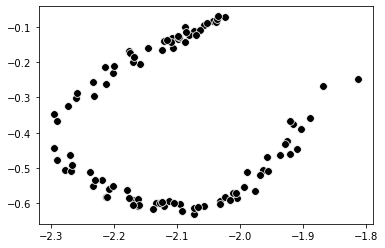

(2, 100)


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [310]:
encoder_w = network_initializer([2, 10, 10, 10, 1], 1)
decoder_w = network_initializer([1, 10, 10, 10, 2], 1)

w = [encoder_w, decoder_w]

X = np.loadtxt(datapath + 'universal_autoencoder_samples.csv', delimiter=',')
plt.scatter(X[0,:], X[1,:], c = 'k', s = 60, linewidth = 0.75, edgecolor = 'w')
plt.show()

dataset = {'input': X,'output': X}

acc_history, cost_history, w = train(encoder_decoder_model, w, dataset,ls_loss, alpha=0.01, epoch_total=50000)

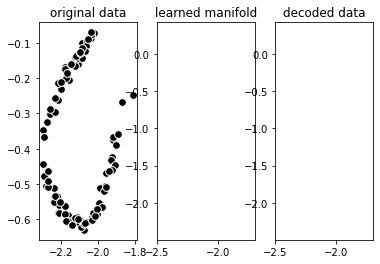

In [311]:
plot_scatter_manifold(X, encoder_decoder_model ,w)

# 13.8

In [197]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from autograd import value_and_grad
from matplotlib import gridspec
import autograd.numpy as np
import matplotlib.pyplot as plt


In [200]:
#preprocessing

x, y = fetch_openml('mnist_784', version=1, return_X_y=True)


y = np.array([int(v) for v in y])[:,np.newaxis]

x = (x - x.mean()) / x.std()

x = x.values.T
y = y.T

print("input shape = " , x.shape)
print("output shape = ", y.shape)


input shape =  (784, 70000)
output shape =  (1, 70000)


In [188]:
#split half

r = np.random.permutation(x.shape[1])
train_num = int(np.round(0.5*len(r)))
train_inds = r[:train_num]
val_inds = r[train_num:]
        
# define training and testing set

x_train = x[:,train_inds]
x_test = x[:,val_inds]

y_train = y[:,train_inds]
y_test = y[:,val_inds]

In [190]:
class Model:
    def __init__(self, layer_sizes, scale, use_BN=True, activation=np.tanh):
        self.weights = self.network_initializer(layer_sizes, scale)
        if use_BN:
            self.mus = None
            self.sigmas = None
        self.train = True
        self.use_BN = use_BN
        self.activation = activation
        
    def set_train(self, t):
        self.train = t
        
    def feature_transforms (self, a, w):
        if self.train and self.use_BN:
            mus = []
            sigmas = []
            # loop through each layer
        for i, W in enumerate(w):
            # compute inner -product with current layer weights
            a = W[0] + np.dot(a.T, W[1:])
            # pass through activation
            a = self.activation (a)
                
            if self.use_BN:
                # BN
                if self.train:
                    mu = np.mean(a, axis=0)
                    # sigma = ((a - mu) ** 2).mean(axis=0)
                    sigma = np.std(a-mu, axis=0)
                    mus.append(mu)
                    sigmas.append(sigma)
                else:
                    mu = self.mus[i]
                    sigma = self.sigmas[i]
                if np.isnan(mu).any():
                    raise ValueError()
                
                if np.isnan(sigma).any():
                    raise ValueError()
                a = (a - mu) / (sigma + 1e-11)
                
            if np.isnan(a).any():
                raise ValueError()
            a = a.T
        if self.train and self.use_BN:
            self.mus = mus
            self.sigmas = sigmas
        return a

    # neural network model
    def model(self, x, theta):
        # compute feature transformation
        f = self.feature_transforms (x, theta [0])
        # compute final linear combination
        a = theta [1][0] + np.dot(f.T, theta[1][1:])
        return a.T
    
    # create initial weights for a neural network model
    def network_initializer (self, layer_sizes, scale):
        # container for all tunable weights
        weights = []
        # create appropriately -sized initial
        # weight matrix for each layer of network
        for k in range(len( layer_sizes ) -1):
            # get layer sizes for current weight matrix
            U_k = layer_sizes [k]
            U_k_plus_1 = layer_sizes [k+1]
        # make weight matrix
            weight = scale * np.random.randn(U_k+1, U_k_plus_1)
            weights.append(weight)
    # repackage weights so that theta_init [0] contains all
    # weight matrices internal to the network, and theta_init [1]
    # contains final linear combination weights
        theta_init = [weights [: -1], weights [ -1]]
        return theta_init


In [191]:
def gradient_descent_optimizer(w, dw, alpha=0.01):
    def grad(W, DW):
        assert len(W) == len(DW)
        if type(W) == list:
            for i in range(len(W)):
                grad(W[i], DW[i])
        elif type(W) == np.ndarray:
            if(np.isnan(DW).any()):
                print(DW, DW.shape)
            W -= alpha * DW
        else:
            raise NotImplemented()
    grad(w, dw)
    return w


# evaluate accuracy of the model
def evaluate(model, w, dataset):
    x = dataset['input']
    y = dataset['output']
    dataset_size = x.shape[1]
    output = model(x, w)
    output_label = output.argmax(axis=0)
    corrects = abs(output.argmax(axis=0) - y) < 1e-6
    return sum(corrects[0]) / dataset_size


def train(model_obj, dataset, dataset_eval, loss_f, alpha=0.01,epoch_total=1000, show_freq=1000):
    w = model_obj.weights
    x = dataset['input']
    y = dataset['output']
    dataset_size = x.shape[0]
    cost_history = []
    acc_history = []
    
    # define loss function
    def get_loss(x, w, y):
        output = model_obj.model(x, w)
        loss = loss_f(output, y)
        return loss

    loss_and_dloss = value_and_grad(get_loss, 1)
    epoch = 0
    
    while epoch < epoch_total:
        loss, grad_value = loss_and_dloss(x, w, y)
        model_obj.set_train(False)
        acc_history.append(evaluate(model_obj.model, w, dataset_eval))
        model_obj.set_train(True)
        cost_history.append(loss)

        # gradient descent step
        w = gradient_descent_optimizer(w, grad_value, alpha)
        
        epoch += 1
        
        if epoch % show_freq == 0 or epoch == 1:
    return acc_history, cost_history, w 


# softmax function
def softmax(x):
    # optimized softmax
    e_x = np.exp(x - np.max(x, axis=0))
    return e_x / e_x.sum(axis=0)


# multi-class cross entropy loss with softmax
def ce_loss(output, label):
    y = softmax(output)
    ret = y[label[0], np.arange(y.shape[1])]
    ret = -np.log(ret + 1e-11).mean()
    return ret

In [205]:
dataset = {'input': x_train.T, 'output': y_train.T}
eval_dataset = {'input': x_test.T, 'output': y_test.T}


model_obj_std = Model([784, 10, 10, 10, 10, 10], 1, False, activation=lambda x: np.maximum(x, 0))
acc_history_std, cost_history_std, w = train(model_obj, dataset, eval_dataset,ce_loss, alpha=0.1, 
                                             epoch_total=1000, show_freq=10)

model_obj_b_n = Model([784, 10, 10, 10, 10, 10], 1, activation=lambda x: np.maximum(x, 0))
acc_history_b_n, cost_history_b_n, w = train(model_obj, dataset, eval_dataset,ce_loss, alpha=0.1, epoch_total=1000)


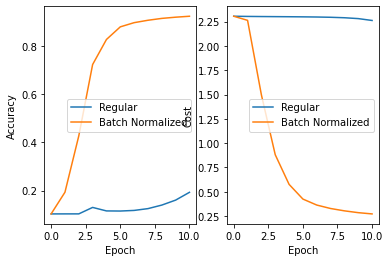

In [203]:
fig = plt.figure()
gs = gridspec.GridSpec(1, 2)

plt.subplot(gs[0]).set_xlabel('Epoch')
plt.subplot(gs[0]).set_ylabel('Accuracy')
plt.subplot(gs[0]).plot(np.arange(len(acc_history_std)), acc_history_std, label="Regular")
plt.subplot(gs[0]).plot(np.arange(len(acc_history_b_n)), acc_history_b_n,label='Batch Normalized')
plt.subplot(gs[0]).legend()

plt.subplot(gs[1]).set_xlabel('Epoch')
plt.subplot(gs[1]).set_ylabel('Cost')
plt.subplot(gs[1]).plot(np.arange(len(cost_history_std)), cost_history_std, label="Regular")
plt.subplot(gs[1]).plot(np.arange(len(cost_history_b_n)), cost_history_b_n, label='Batch Normalized')
plt.subplot(gs[1]).legend()

plt.show()

# 13.9

In [255]:
from copy import deepcopy
from matplotlib import gridspec

In [256]:
def evaluate(model, w, dataset):
    x = dataset['input']
    y = dataset['output']
    dataset_size = x.shape[1]
    output = model(x, w)
    return abs(output-y).sum()

def train(model_obj, dataset, dataset_eval, loss_f, alpha=0.01, epoch_total=1000, show_freq=1000):
    w = model_obj.weights

    x = dataset['input']
    y = dataset['output']
    print(x.shape)
    dataset_size = x.shape[0]
    cost_history = []
    acc_history = []
    # define loss function
    def get_loss(x, w, y):
        output = model_obj.model(x, w)
        loss = loss_f(output, y)
        return loss
    loss_and_dloss = value_and_grad(get_loss, 1)
    min_mse = 1e10
    min_w = w
    epoch = 0
    while epoch < epoch_total:
        loss, grad_value = loss_and_dloss(x, w, y)
        model_obj.set_train(False)
        acc_history.append(evaluate(model_obj.model, w, dataset_eval))
        model_obj.set_train(True)
        cost_history.append(loss)
        if acc_history[-1] < min_mse:
            min_mse = acc_history[-1]
            min_w = deepcopy(w)
        # gradient descent step
        w = gradient_descent_optimizer(w, grad_value, alpha)
        epoch += 1
        if epoch % show_freq == 0 or epoch == 1:
            print('epoch: %d, accuracy: %f, loss: %f' % (epoch,acc_history[-1], cost_history[-1]))
    return acc_history, cost_history, w, min_w

def ls_loss(output, gt):   
    ret = np.power(output-gt, 2).sum(axis=0)
    ret = ret.mean()
    return ret

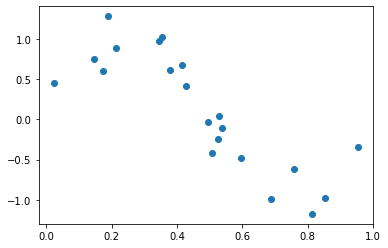

In [257]:
#dataset
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname, delimiter = ',')

x = data[:-1,:]
y = data[-1:,:]

fig = plt.figure()
plt.scatter(x, y)
plt.show()


In [258]:
x_train, x_test, y_train, y_test = train_test_split(x.T, y.T, test_size=0.5)

dataset = {'input': x_train.T, 'output': y_train.T}

eval_dataset = {'input': x_test.T, 'output': y_test.T}

model_obj = Model([1, 10, 10, 10, 1], 1, False)

acc_history, cost_history, w, best_w = train(model_obj, dataset, eval_dataset, ls_loss, alpha=0.01, epoch_total=20000)

(1, 10)
epoch: 1, accuracy: 55.425319, loss: 24.218639
epoch: 1000, accuracy: 2.309508, loss: 0.029591
epoch: 2000, accuracy: 1.968931, loss: 0.026260
epoch: 3000, accuracy: 2.167364, loss: 0.025609
epoch: 4000, accuracy: 2.292671, loss: 0.025418
epoch: 5000, accuracy: 2.380893, loss: 0.025348
epoch: 6000, accuracy: 2.447026, loss: 0.025313
epoch: 7000, accuracy: 2.499559, loss: 0.025288
epoch: 8000, accuracy: 2.543512, loss: 0.025268
epoch: 9000, accuracy: 2.581843, loss: 0.025250
epoch: 10000, accuracy: 2.616295, loss: 0.025233
epoch: 11000, accuracy: 2.647913, loss: 0.025218
epoch: 12000, accuracy: 2.677342, loss: 0.025203
epoch: 13000, accuracy: 2.705000, loss: 0.025189
epoch: 14000, accuracy: 2.731179, loss: 0.025176
epoch: 15000, accuracy: 2.756095, loss: 0.025163
epoch: 16000, accuracy: 2.779919, loss: 0.025151
epoch: 17000, accuracy: 2.802788, loss: 0.025140
epoch: 18000, accuracy: 2.824822, loss: 0.025129
epoch: 19000, accuracy: 2.846119, loss: 0.025118
epoch: 20000, accuracy:

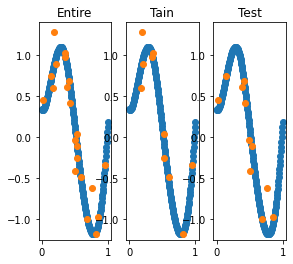

In [259]:
fig = plt.figure()
gs = gridspec.GridSpec(1, 4)

x_line = np.linspace(0, 1, 200).reshape(1, 200)
y_line = model_obj.model(x_line, best_w)


plt.subplot(gs[0]).set_title('Entire')
plt.subplot(gs[0]).set_ylim(-1.25, 1.4)
plt.subplot(gs[0]).scatter(x_line, y_line)
plt.subplot(gs[0]).scatter(x, y)

plt.subplot(gs[1]).set_title('Tain')
plt.subplot(gs[1]).set_ylim(-1.25, 1.4)
plt.subplot(gs[1]).scatter(x_line, y_line)
plt.subplot(gs[1]).scatter(x_train, y_train)

plt.subplot(gs[2]).set_title('Test')
plt.subplot(gs[2]).set_ylim(-1.25, 1.4)
plt.subplot(gs[2]).scatter(x_line, y_line)
plt.subplot(gs[2]).scatter(x_test, y_test)


plt.show()


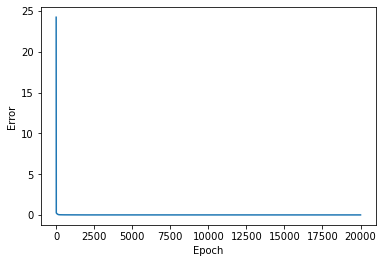

In [260]:
fig = plt.figure()

gs = gridspec.GridSpec(1, 1)

plt.subplot(gs[0]).set_xlabel('Epoch')
plt.subplot(gs[0]).set_ylabel('Error')

plt.subplot(gs[0]).plot(np.arange(len(cost_history)), cost_history)

plt.show()

# 13.10

In [283]:
from sklearn.datasets import fetch_openml
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [284]:
def evaluate(model, w, dataset):
    x = dataset['input'].values()
    y = dataset['output'].values()
    dataset_size = x.shape[1]
    output = model(x, w)
    output_label = output.argmax(axis=0)
    corrects = abs(output.argmax(axis=0) - y) < 1e-6
    return sum(corrects[0]) / dataset_size


def train(model_obj, dataset, dataset_eval, loss_f, alpha, epoch_total, show_freq):
    w = model_obj.weights
    x, x_valid = dataset['input'], dataset_eval['input']
    y, y_valid = dataset['output'], dataset_eval['output']
    
    print(x.shape)
    print(y.shape)
    print(x_valid.shape)
    print(y_valid.shape)
    
    dataset_size = x.shape[1]
    cost_history_train = []
    cost_history_val = []
    acc_history_train = []
    acc_history_val = []
    
    # define loss function
    def get_loss(x, w, y):
        output = model_obj.model(x, w)
        loss = loss_f(output, y)
        return loss
    
    loss_and_dloss = value_and_grad(get_loss, 1)
    
    batchsize = 200
    epoch = 0
    
    while epoch < epoch_total:
        for b_start in range(0, dataset_size, batchsize):
            x_batch = x[..., b_start: b_start + batchsize]
            y_batch = y[..., b_start: b_start + batchsize]
            loss, grad_value = loss_and_dloss(x_batch, w, y_batch)
            
            # gradient descent step
            w = gradient_descent_optimizer(w, grad_value, alpha)
            
        model_obj.set_train(False)
        
        acc_history_train.append(evaluate(model_obj.model, w, dataset))
        acc_history_val.append(evaluate(model_obj.model, w, dataset_eval))
        
        model_obj.set_train(True)
        
        cost_history_train.append(loss)
        loss_valid, _ = loss_and_dloss(x_valid, w, y_valid)
        cost_history_val.append(loss_valid)
        
        epoch += 1
        
        if epoch % show_freq == 0 or epoch == 1:
            print('epoch: %d, accuracy: %f, loss: %f' % (epoch,acc_history_val[-1], cost_history_train[-1]))
            
    return acc_history_train, acc_history_val, cost_history_train,cost_history_val



In [285]:
#preprocessing

x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# convert string labels to integers
y = np.array([int(v) for v in y])[:,np.newaxis]

x = (x - x.mean()) / x.std()
#x = x.values.T
#y = y.T

print("input shape = " , x.shape)
print("output shape = ", y.shape)


input shape =  (70000, 784)
output shape =  (70000, 1)


In [286]:
#split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test,test_size=0.5)


In [287]:
dataset = {'input': x_train.T, 'output': y_train.T}

v_dataset = {'input': x_valid.T, 'output': y_valid.T}


model_obj = Model([784, 100, 100, 10], 1, activation=lambda x: np.maximum(x, 0))
acc_history_train, acc_history_val, cost_history_train, cost_history_val =train(model_obj, dataset, v_dataset, ce_loss,
                                                                                0.1, 1000, 10)

(784, 35000)
(1, 35000)
(784, 17500)
(1, 17500)


TypeError: '(Ellipsis, slice(0, 200, None))' is an invalid key

NameError: name 'acc_history_train' is not defined

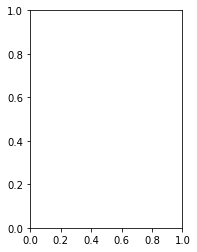

In [281]:
fig = plt.figure()

gs = gridspec.GridSpec(1, 2)

plt.subplot(gs[1]).plot(np.arange(len(acc_history_train)), acc_history_train, label="train")
plt.subplot(gs[1]).plot(np.arange(len(acc_history_val)), acc_history_val, label='validation')
plt.subplot(gs[1]).legend()
plt.subplot(gs[1]).set_xlabel('epoch')
plt.subplot(gs[1]).set_ylabel('accuracy')


plt.subplot(gs[0]).plot(np.arange(len(cost_history_train)), cost_history_train)
plt.subplot(gs[0]).plot(np.arange(len(cost_history_val)), cost_history_val)
plt.subplot(gs[0]).set_xlabel('epoch')
plt.subplot(gs[0]).set_ylabel('cost')
plt.show()